In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

I kept the Name FeatureEngineering to avoid confusion, but it's Data cleaning of the seadevcon data log from Ship W50DF_00092 Engine 01 that is done in this Notebook. Runlog and SeaDevCon_AISdailyaggregates_sanitized are <u>NOT</u> used or cleaned here. The Predictions in the "Modelling" Notebook are only based on the cleaned seadevcon data of engine 1 of this one Ship. I hope this helps to avoid confusion. 

P.s. please excuse some errors and (smaller) mistakes in the last version of this, I worked on it between 7 pm and 5 am. I tried to make this Version more understandable and fixed some bugs.

<h1>Read in the data:</h1>

In [9]:
PATH = "/Users/basti/Documents/MLDatasets/SeaDevConChallange/"
SHIP1 = PATH + "W50DF_00092/"
SHIP1_engine1 = "W50DF_00092" + "_01"
ship1_seadevcon_init = pd.read_csv(SHIP1 + "W50DF_00092_01_seadevcon.csv") # 0:MDF = Diesel # HFO = Heavy fule oil # Gas
# ship1_runlog_init = pd.read_csv(SHIP1 + "W50DF_00092_01_runlog.csv") # only seadevcon will be cleaned in this file.
# ships_info = pd.read_csv(PATH + "SeaDevCon_AISdailyaggregates_sanitized.csv", sep=';') # error_bad_lines=False -> entfernt die lines aber, das vielleicht nicht so gut.
tags = pd.read_csv(PATH + "SensorTags_SeaDevCon.csv", sep='\t', header=None)

Information from the ship expert:

Potential reasons why the ship is not running on Gas:
- Gas tank is empty
- Gas tank getting to hot resulting in high pressure and burning of hight amounts of Gas (maybe some Gas is wasted while this)


In [56]:
SHIP = "W50DF_00092"

<h2> Remove 2/3 of the features (min/max values) </h2>

In [11]:
print("Before:",ship1_seadevcon_init.shape)
remove_tags = []
for colTag in ship1_seadevcon_init:
    if "_max" in colTag or "_min" in colTag:
        remove_tags.append(colTag)

ship1_seadevcon = ship1_seadevcon_init.drop(remove_tags, axis=1)
print("After: ",ship1_seadevcon.shape)
print("Removed",len(remove_tags),"features")

Before: (699768, 249)
After:  (699768, 87)
Removed 162 features


<h1>Plot the Tables</h1>

In [55]:
print("Seadevcon:")
print(ship1_seadevcon.shape)
ship1_seadevcon.head()

Seadevcon:
(406715, 83)


,"Enclosure underpressure GVU, PDS01",Inlet gas pressure,Gas pressure between shut-off valves,Inert gas pressure,"Instrument air pressure GVU, PT006",Inlet gas temperature,Fuel rack control,Exh WG valve control value,By Pass valve control,"MFI duration offset, cyl A1",...,"CA temp, engine inlet, TE601","Engine exh. gas average temp, TY500","Engine load feedback, torque","Torsional vibration level, mean",Calculated engine load,RunNumber,MinutesSinceStart,CumRunningHours,FuelTypeAnalog,Load
1828,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.236111,0.0,97.683335,...,39.700001,476.299988,52.844200,114.898305,2821.50,42,334.0,25.022318,2,48.741905
1829,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.229268,0.0,97.741669,...,39.700001,476.299988,52.770000,129.127119,2741.70,42,336.0,25.055651,2,48.754955
1830,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.285106,0.0,97.800003,...,39.700001,476.299988,53.109362,120.689655,2781.60,42,338.0,25.088984,2,48.705455
1831,-57.620690,5.8,5.86,8.53,6.320,38.700001,0.0,17.945238,0.0,97.800003,...,39.700001,476.299988,52.574340,122.145299,2844.30,42,340.0,25.122318,2,48.128070
1832,-57.463415,5.8,5.86,8.53,6.315,38.700001,0.0,18.168182,0.0,97.400002,...,39.700001,476.299988,53.131538,115.230769,2847.15,42,342.0,25.155651,2,48.594643


In [14]:
# this is not used in this file any more.
# print("Ship Runlog")
# print(ship1_runlog_init.shape)
# ship1_runlog_init.head()

In [15]:
# this is not used in this file any more.
# print("AIS daily aggregates")
# print(ships_info.shape)
# ships_info.head()

In [16]:
print("Sensor Tags")
print(tags.shape)
tags.head()

Sensor Tags
(2669, 4)


,0,1,2,3
0,3,W50_00059_01,BAG011UP01PV,Generator max. active power
1,93,W50_00059_01,SCA011CV124PV,Pilot FO press control
2,94,W50_00059_01,SCA011CV161PV,"Fuel Rack Control, CV161"
3,95,W50_00059_01,SCA011CV432PV,"HT valve position, control value"
4,96,W50_00059_01,SCA011CV493PV,"LT valve position, control value"


<h1>Replace column name tags with real names </h1>

In [17]:
columns = list(ship1_seadevcon.columns.values)
for i, colTag in enumerate(columns):
    # print(colTag)
    # allready removed all _min and _max values above, so this 2 lines below are unnecessary (it was a bad idea anyways).
    # if "_max" in colTag or "_min" in colTag: # remove _min or _max
    #     colTag = colTag[:-4]
    if colTag in tags[2].values:
        # find row in tags dataFrame which contains the current tag that we are searching the name for.
        a = tags.loc[tags[2] == colTag] # a = the rows
        b = a.loc[a[1] == SHIP1_engine1]
        columns[i] = b[3].values[0]
        # print(b[3].values[0])
ship1_seadevcon1 = pd.DataFrame(ship1_seadevcon.values, None, columns) # copies whole dataset into new pd frame. Takes a lot of time.

In [18]:
ship1_seadevcon = ship1_seadevcon1

In [19]:
# important for comparison with ship1_runlog. Comparison is done in SomeDataAnalysis Notebook (not here).
print("RunNumber" in ship1_seadevcon) 

True


<h2>Transform text features into Numerical ones</h2>

In [20]:
for col in ['mode','FuelTypeAnalog']:
    labels, uniques = ship1_seadevcon[col].factorize(na_sentinel=-1)
    lab = pd.DataFrame(labels)
    lab[lab < 0] = 'NaN'
    lab = lab.astype(np.float64)
    ship1_seadevcon[col] = lab

# mode and FuelTypeAnalog are float for now. Will be replaced later by bool and int.

<h2>Remove (2) useless features (>80% NaN values)</h2>

In [21]:
PERCENT_NAN_REMOVE = 0.8 # remove features that have more than 80% NaN values
percent_nan = []
remove_tags = []
for col in ship1_seadevcon:
    ship_df = ship1_seadevcon[col]
    nans = np.sum(ship_df.isnull().values)
    percent_nan.append(nans/ship_df.shape[0])
    if percent_nan[-1] > PERCENT_NAN_REMOVE:
        remove_tags.append(col)
print("Removed: ", remove_tags, "because more than",PERCENT_NAN_REMOVE*100,"% are NaN")
ship1_seadevcon = ship1_seadevcon.drop(remove_tags, axis=1)

Removed:  ['ts', 'SCA011GTY1623PV_C'] because more than 80.0 % are NaN


<h2>Remove Rows where the engine is not running</h2>

In [36]:
# plt.plot(list(range(ship1_seadevcon['mode'].shape[0])), ship1_seadevcon['mode'])
# plt.show()

In [37]:
before = ship1_seadevcon.shape[0]
ship1_seadevcon1 = ship1_seadevcon[ship1_seadevcon['mode'] != 0.0]
after = ship1_seadevcon1.shape[0]
print("Removed",before - after,"rows. Equals",np.round((before - after)/before*100,2),"% of the data")

Removed 292278 rows. Equals 41.77 % of the data


In [38]:
ship1_seadevcon = ship1_seadevcon1
ship1_seadevcon = ship1_seadevcon.drop('mode', axis=1)
ship1_seadevcon.head()

,"Enclosure underpressure GVU, PDS01",Inlet gas pressure,Gas pressure between shut-off valves,Inert gas pressure,"Instrument air pressure GVU, PT006",Inlet gas temperature,Fuel rack control,Exh WG valve control value,By Pass valve control,"MFI duration offset, cyl A1",...,"CA temp, engine inlet, TE601","Engine exh. gas average temp, TY500","Engine load feedback, torque","Torsional vibration level, mean",Calculated engine load,RunNumber,MinutesSinceStart,CumRunningHours,FuelTypeAnalog,Load
0,-0.00588462,0.02,0,8.56,6.29,23.2,NaN,0,NaN,100,...,43.7,70.3,NaN,0,0,NaN,NaN,NaN,0.0,0
356,NaN,NaN,NaN,NaN,6.295,NaN,51.7833,NaN,NaN,NaN,...,NaN,117.621,1815.55,66.3419,NaN,1,0,-0.000273611,0.0,NaN
357,NaN,NaN,NaN,NaN,6.29,NaN,25.8917,NaN,NaN,NaN,...,46.9,171.7,1831.88,41.9735,NaN,1,2,0.0330597,0.0,NaN
358,NaN,NaN,NaN,NaN,6.29,NaN,0,NaN,NaN,NaN,...,49,142.133,1109.89,146.329,NaN,1,4,0.0663931,0.0,NaN
685,-57.5,NaN,NaN,8.29,6.28,NaN,0,NaN,NaN,NaN,...,NaN,NaN,196.316,NaN,NaN,NaN,NaN,NaN,0.0,NaN


<h2>Interpolate the missing data featurewise</h2>

In [39]:
# Transform to float so interpolate() works below (mode and FuelTypeAnalog must be factorized already)
for col in ship1_seadevcon:
    ship1_seadevcon[col] = ship1_seadevcon[col].astype(np.float64)
ship1_seadevcon = ship1_seadevcon.interpolate(limit=8, limit_direction='both')
ship1_seadevcon.head()

,"Enclosure underpressure GVU, PDS01",Inlet gas pressure,Gas pressure between shut-off valves,Inert gas pressure,"Instrument air pressure GVU, PT006",Inlet gas temperature,Fuel rack control,Exh WG valve control value,By Pass valve control,"MFI duration offset, cyl A1",...,"CA temp, engine inlet, TE601","Engine exh. gas average temp, TY500","Engine load feedback, torque","Torsional vibration level, mean",Calculated engine load,RunNumber,MinutesSinceStart,CumRunningHours,FuelTypeAnalog,Load
0,-0.005885,0.0200,0.0,8.5600,6.290,23.200001,51.783333,0.0,NaN,100.0,...,43.700001,70.300003,1815.545455,0.000000,0.0,1.0,0.0,-0.000274,0.0,0.0
356,-14.379413,0.0175,0.0,8.4925,6.295,23.012501,51.783333,0.0,NaN,100.0,...,45.300000,117.620833,1815.545455,66.341880,0.0,1.0,0.0,-0.000274,0.0,0.0
357,-28.752942,0.0150,0.0,8.4250,6.290,22.825001,25.891667,0.0,NaN,100.0,...,46.900000,171.700000,1831.880342,41.973451,0.0,1.0,2.0,0.033060,0.0,0.0
358,-43.126471,0.0125,0.0,8.3575,6.290,22.637501,0.000000,0.0,NaN,100.0,...,49.000000,142.133333,1109.888889,146.329268,0.0,1.0,4.0,0.066393,0.0,0.0
685,-57.500000,0.0100,0.0,8.2900,6.280,22.450001,0.000000,0.0,0.0,100.0,...,47.960000,127.866667,196.315789,117.063415,0.0,1.1,3.6,0.069143,0.0,0.0


<h2>Replace NaN values with interpolate if there are less than 0.2% NaN</h2>

In [40]:
PERCENT_NAN_REMOVE = 0.002 # remove features that have more than 0.2% NaN values # others replace with interpolation
percent_nan = []
remove_tags = []
for col in ship1_seadevcon:
    ship_df = ship1_seadevcon[col]
    nans = np.sum(ship_df.isnull().values)
    percent_nan.append(nans/ship_df.shape[0])
    if percent_nan[-1] > PERCENT_NAN_REMOVE:
        remove_tags.append(col)
ship1_seadevcon = ship1_seadevcon.drop(remove_tags, axis=1) # remove tags
print("Removed: ", remove_tags, "because more than",PERCENT_NAN_REMOVE*100,"% are NaN")

# interpolate the rest:
ship1_seadevcon = ship1_seadevcon.interpolate()

Removed:  ['Global MFI demand, gas'] because more than 0.2 % are NaN


In [41]:
# Change to usefull dtypes:
# ship1_seadevcon['mode'] = ship1_seadevcon['mode'].astype(np.bool) # removed
ship1_seadevcon['FuelTypeAnalog'] = ship1_seadevcon['FuelTypeAnalog'].astype(np.int8)
ship1_seadevcon['RunNumber'] = ship1_seadevcon['RunNumber'].astype(np.int32) # HERE WAS A MISTAKE. 
    # ofcause int8 was not enough to represent all run numbers.

# plot data in between ... (what head() is not printing):
# ship1_seadevcon.iloc[:,30:50]
# ship1_seadevcon.iloc[:,50:70]

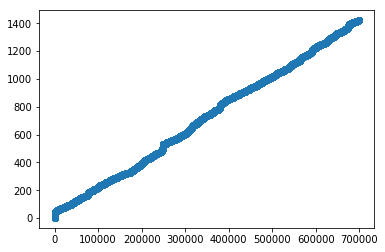

In [42]:
# Problem from last version is fixed. Run Numbers are correct now
plt.scatter(ship1_seadevcon["RunNumber"].index,ship1_seadevcon["RunNumber"])
plt.show()

In [43]:
print(ship1_seadevcon.shape)

(407490, 83)


In [48]:
# check if columns have NaN values:
remove_tags = []
for col in ship1_seadevcon:
    if ship1_seadevcon[col].isnull().values.any():
        print(col, "still has NaN values but only rows will be removed below, not the whole column.")
        remove_tags.append(col)
# remove ->column<-:
# ship1_seadevcon = ship1_seadevcon.drop(remove_tags, axis=1)

By Pass valve control still has NaN values but only rows will be removed below, not the whole column
Fuel demand, pptt still has NaN values but only rows will be removed below, not the whole column


<h2>Remove <u>Rows</u> that are still NaN</h2>

In [46]:
ship1_seadevcon.shape

(407490, 83)

In [49]:
before = ship1_seadevcon.shape
ship1_seadevcon = ship1_seadevcon.dropna(axis=0) # <---------- dropna
print("Removed", (before[0] - ship1_seadevcon.shape[0]), "rows because at least one feature had NaN value")
print("This is", np.round((before[0] - ship1_seadevcon.shape[0])/before[0]*100, 2),"% of the whole dataset")

Removed 775 rows because at least one feature had NaN value
This is 0.19 % of the whole dataset


In [50]:
''' Save ship1_seadevcon to file'''
ship1_seadevcon.to_pickle("ship1_seadevcon")

<h1>Inspect Objective</h1>

In [12]:
ful = ship1_seadevcon['FuelTypeAnalog']
print(ful[608580]) # HFO -> 3 # 424
print(ful[964])    # Gas -> 2 # 340022
print(ful[931])    # GasDiesel -> 1 # 12031
print(ful[20])     # MDF -> 0 # MDF # 347269
# print(len(np.where(ful[:] == "MDF")[0]))

HFO
Gas
GasDiesel
MDF


In [51]:
# Remove outliers from Objective (FuelTypeAnalog):
# ship1_seadevcon = ship1_seadevcon[ship1_seadevcon['FuelTypeAnalog'] < 3] # 3 ist Schweröl. Nicht rausnehmen!
objective = ship1_seadevcon['FuelTypeAnalog']

In [52]:
#print(ship1_seadevcon.columns.values)

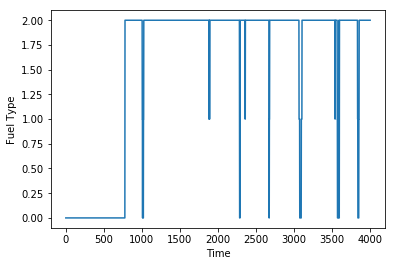

As we can see, sometimes the engin runs with Diesel instead of Gas. This is expensive.
Heavy Oil -> 3   (42)
Gas -> 2         (340022)
GasDiesel -> 1   (12031)
Diesel -> 0      (347269)


In [53]:
# Plot an interesting area of Objective
obj = objective[34000:38000]
plt.plot(range(obj.shape[0]), obj)
plt.xlabel("Time")
plt.ylabel("Fuel Type")
plt.show()
print("As we can see, sometimes the engin runs with Diesel instead of Gas. This is expensive.")
print("Heavy Oil -> 3   (42)")
print("Gas -> 2         (340022)")
print("GasDiesel -> 1   (12031)")
print("Diesel -> 0      (347269)")

<h3>It's important to note that the use of diesel is mainly in the beginning. Please see Some_Data_Analysis Notebook for further details on changes in diesel/gas and oil use over the years!</h3>

This data Cleaning was carried out by Sebastian Nichtern (https://www.linkedin.com/in/sebastiannichtern/)